In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.tsa.ar_model as ar_model
import statsmodels.api as sm
from scipy import stats

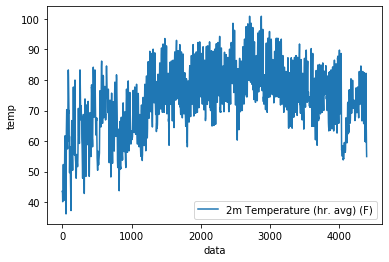

In [2]:
## Accessing the temperature data from input csv file. 
input_data = pd.read_csv("3.csv")
input_data
input_data.plot()
plt.xlabel('data')
plt.ylabel('temp')
plt.show()

From the plotting the dataset we can see that the data mean mean of the data varies along the time as well as the variance of the data set changes from time. Thus we can see that the given data is not stationary data. To make the dataset stationary we will perform differencing and log differencing and will decide which transform we will use to make the data stationary.

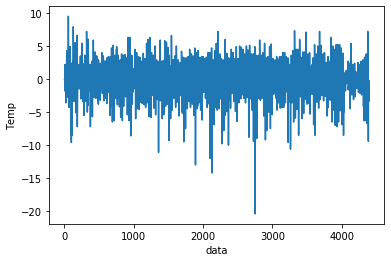

In [3]:
## Accessing the temperature data from input csv file and perfroming differencing on the data.
temperature = input_data['2m Temperature (hr. avg) (F)']
diff = input_data['2m Temperature (hr. avg) (F)'] - input_data['2m Temperature (hr. avg) (F)'].shift(1)
diff.plot()
plt.xlabel('data')
plt.ylabel('Temp')
plt.show()

After performing diferencing of the data x(t+1) - x(t) we can see that the mean of of the data doesnt vary much but still the variance of the data is very high as min temperature is around -20 and having maximum temperature around 10. Thus we will do log differencing on the data to see if can achieve better stationarity.  

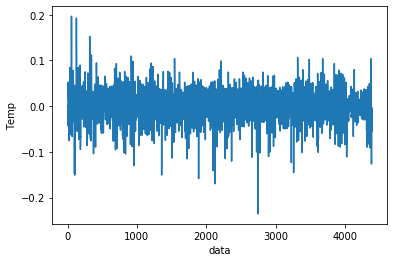

In [4]:
## Accessing the temperature data from input csv file and perfroming log-differencing on the data.
log_diff_temp = np.log(input_data['2m Temperature (hr. avg) (F)'][1:]) - np.log(input_data['2m Temperature (hr. avg) (F)'].shift(1)[1:])
plt.plot(log_diff_temp)
plt.xlabel('data')
plt.ylabel('Temp')
plt.show()

After performing log differencing log(x(t+1)) - log(x(t)) we see that the data has constant mean and the small variance and no we can see that the data has stationarity.

In [5]:
## Splitting the temperature data into 2 equal portions.
x_train = log_diff_temp[:int(np.ceil(0.5*len(log_diff_temp)))]
x_test = log_diff_temp[int(np.ceil(0.5*len(log_diff_temp))):]
x_train.shape, x_test.shape

((2196,), (2196,))

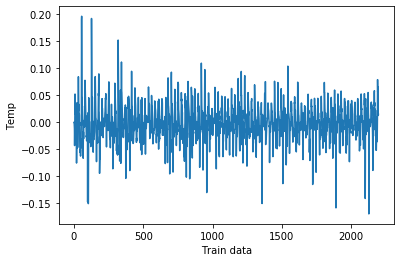

In [6]:
## Plotting training data.
plt.plot(x_train)
plt.xlabel('Train data')
plt.ylabel('Temp')
plt.show()

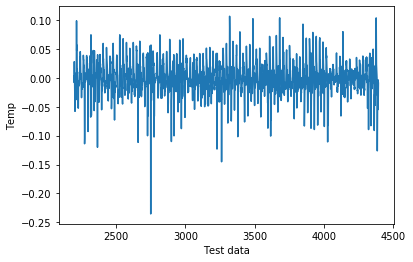

In [7]:
## Plotting testing data.
plt.plot(x_test)
plt.xlabel('Test data')
plt.ylabel('Temp')
plt.show()

k value for minimum RMSE is  1
minimum RMSE is  0.0


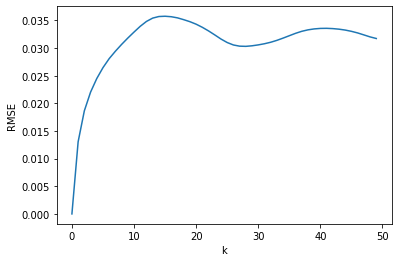

In [8]:
## Implemengint Simple Moving Average on training data with varying k value and plotting RMSE vs k.
sma_rmse = []
k = []
for i in range(1,51):
    k.append(i)
    y = x_train[i:]
    y_pred = x_train.rolling(i).mean()[i:]
    sma_rmse.append(mean_squared_error(y, y_pred, squared=False))
plt.plot(sma_rmse)
plt.xlabel('k')
plt.ylabel('RMSE')
print('k value for minimum RMSE is ', sma_rmse.index((min(sma_rmse)))+1)
print('minimum RMSE is ', (min(sma_rmse)))
k_optim = sma_rmse.index((min(sma_rmse)))+1

From the above RMSE vs k plot we can see that as the window size for SMA increases the RMS error also increases. The minimum value for error is 0 when the window size is 1 that is the value can be predicted by simply averaging the most recent past value (t-1) value and current value.

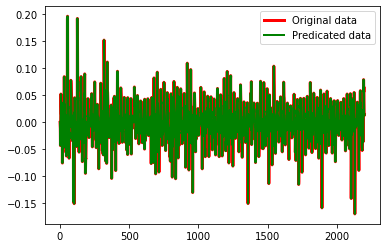

In [9]:
## Plotting prediction for train data using above calculated window size.
y = x_train[k_optim:]
y_pred = x_train.rolling(k_optim).mean()[k_optim:]
sma_rmse.append(mean_squared_error(y, y_pred, squared=False))
plt.plot(y, color='red', linewidth = 3, label = 'Original data')
plt.plot(y_pred, color = 'green', linewidth = 2, label = 'Predicated data')
plt.legend(loc = 'upper right')
plt.show()

From the above plot from predicted values and the original data we can see that the SMA model can predict the data very well.

RMSE for alpha = 0.1 is 0.029362398873807732
alpha value for minimum RMSE is  0.9
minimum RMSE is 0.00259155621094734


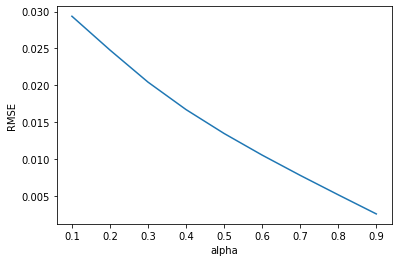

In [10]:
## Implemengint Exponential Moving Average on training data with varying alpha = 0.1 and calcularing RMSE.
y = x_train[1:]
y_pred1 = x_train.ewm(alpha = 0.1).mean()[1:]
error = mean_squared_error(y, y_pred1 , squared = False)
print('RMSE for alpha = 0.1 is', error)
## Implemengint Exponential Moving Average on training data with varying alpha value and plotting RMSE vs alpha.
ema_rmse = []
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.9]
for i in alpha:
    y_pred = x_train.ewm(alpha = i).mean()[1:]
    ema_rmse.append(mean_squared_error(y, y_pred, squared = False))

plt.plot(alpha, ema_rmse)
plt.xlabel('alpha')
plt.ylabel('RMSE')
print('alpha value for minimum RMSE is ', (ema_rmse.index((min(ema_rmse)))+1)/10)
print('minimum RMSE is', min(ema_rmse))
alpha_optim = ema_rmse.index((min(ema_rmse)))/10

From the above RMSE vs Alpha plt we can see that the RMSE error decreases as the alpha value is increasing. Thus we will choose alpha = 0.8 which has the minimum error value.  

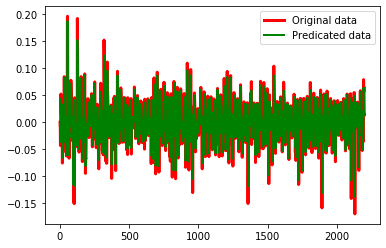

In [11]:
## Plotting prediction for train data using above calculated alpha value.
y = x_train[1:]
y_pred = x_train.ewm(alpha = alpha_optim).mean()[1:]
plt.plot(y, color='red', linewidth = 3, label = 'Original data')
plt.plot(y_pred, color = 'green', linewidth = 2, label = 'Predicated data')
plt.legend(loc = 'upper right')
plt.show()

From above plot of training data and predictions for the training data we can see that the predicted value for the given data is good and have a low RMSE value of 0.00259155621094734. But we can also see some of the predicted values do not match the real values for which there is sudden change(peak values).

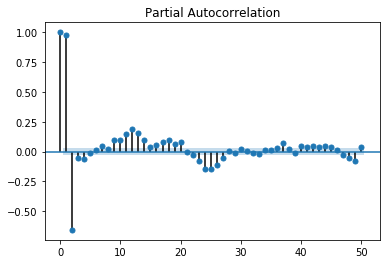

In [12]:
## Plotting Partial Autocorrelation Function.
temp = temperature.head(int(len(log_diff_temp)//2))
plot_pacf(temp, lags = 50, alpha = 0.15)
plt.show()

From above Partial autocorreletaion function we can see that for the 6th value the alpha(6th) < threshold which is set to 0.15 as mentioned in the book. Thus we will select 5 as the order for our AR model.

In [13]:
## Implementing AR model.
X = log_diff_temp.values
train, test = X[1:len(X)//2+1], X[len(X)//2+1:]
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(train, lags=5)
model_fit = model.fit()
y_pred = model_fit.predict(end = len(train) - 1, dynamic = False)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                 2196
Model:                     AutoReg(5)   Log Likelihood                5083.924
Method:               Conditional MLE   S.D. of innovations              0.024
Date:                Wed, 21 Oct 2020   AIC                             -7.472
Time:                        21:58:44   BIC                             -7.454
Sample:                             5   HQIC                            -7.466
                                 2196                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.001      0.271      0.786      -0.001       0.001
y.L1           0.7265      0.021     34.078      0.000       0.685       0.768
y.L2          -0.0892      0.026     -3.382      0.001      -0.141      -0.037
y.L3           0.0610      0.026      2.310      0.021       0.009       0.113
y.L4          -0.0104      0.026     -0.394      0.693      -0.062       0.041
y.L5          -0.0638      0.021     -2.991      0.003      -0.106      -0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3306           -0.5069j            1.4239           -0.0579
AR.2            1.3306           +0.5069j            1.4239            0.0579
AR.3           -0.2566           -1.8112j            1.8293           -0.2724
AR.4           -0.2566           +1.8112j            1.8293            0.2724
AR.5           -2.3110           -0.0000j            2.3110           -0.5000
-----------------------------------------------------------------------------
"""

As above show is the summary for the AR model with 5 lags gives us the coefficients for 5 variables and the constant term. I have also predicted the value for training data using the same model and calculated the RMSE error for the model

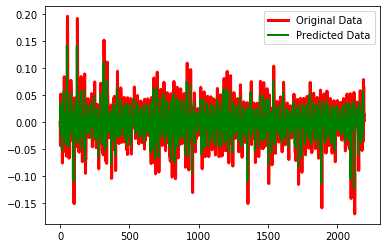

RMSE for the AR model generated above is  0.023770607122187582


In [14]:
## Plotting predicted data generated by model and training data.  
ar_mse = mean_squared_error(train[5:], y_pred, squared=False)
plt.plot(train, color='red', linewidth=3, label = 'Original Data')
plt.plot(y_pred, color = 'green', linewidth=2, label = 'Predicted Data')
plt.legend(loc = 'upper right')
plt.show()
print("RMSE for the AR model generated above is ",ar_mse)

From the aboce plot we can see that the predicted values for the given training data lags to the training data. Thus we can also see that the RMSE for the same model is a bit higher than the SMA and EMA models which is 0.023770607122187582. 

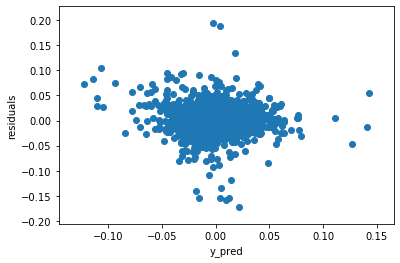

In [15]:
## Plotting scatter diagram for residuals. 
plt.scatter(y_pred, model_fit.resid)
plt.xlabel('y_pred')
plt.ylabel('residuals')
plt.show()

From the above scatter plot we can see that there are no trends between the predicted values and the residuals, as the residuals are neither positvely or negatively correlated to each other.

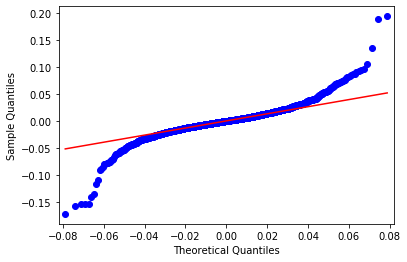

In [16]:
## Plotting QQ Plot for the residuals to check if they are normally distributed.
fig = sm.qqplot(model_fit.resid, loc=0, scale=np.sqrt(np.var(model_fit.resid)), line='q')
plt.show()

From the Above QQ plot we can see that the distribution of the residuals does not exactly matches the normal distribution with zero mean and standard deviation of rht residuals.

In [17]:
## Checking chi-squared hypothesis.
k2, prob = stats.normaltest(model_fit.resid)
if prob < 0.001:
    print("Chi squared test doesnt satisfy hypothesis not accepted")
else:
    print('Chi squared test passed hypothesis accepted')

Chi squared test doesnt satisfy hypothesis not accepted


Text(0, 0.5, 'Frequency')

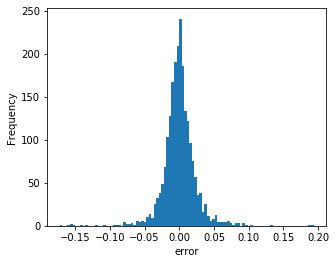

In [18]:
## Plotting histogram for the residuals.
n_bins = 100
fig, ax = plt.subplots(figsize =(5, 4))
ax.hist(model_fit.resid, bins = n_bins)
plt.xlabel("error")
plt.ylabel("Frequency")

From the histogram for the residuals we can see that the residuals have 0 mean and are normally distributed around the mean value. Thus from above results we can see that the residuals generated by the model are not correlated, normally distributed with zero mean the model also gives low RMSE error therefore we can use this model for forecasting values for test data.

MSE for predicted data using SMA is  0.0


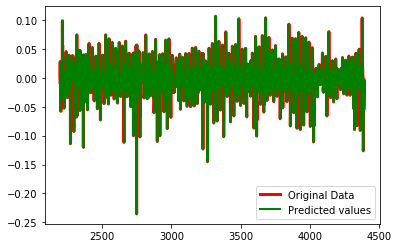

In [19]:
### Comparing the SMA, EMA, AR models generated above by using testing data.
y = x_test[k_optim:]
y_pred = x_test.rolling(k_optim).mean()[k_optim:]
print("MSE for predicted data using SMA is ",mean_squared_error(y, y_pred, squared=False))
## Plotting predicted data predicted by SMA model and testing data.  
plt.plot(y, color='red', linewidth=3, label = 'Original Data')
plt.plot(y_pred, color = 'green', linewidth=2, label = 'Predicted values')
plt.legend()
plt.show()

MSE for predicted data using EMA is  0.004742910756779176


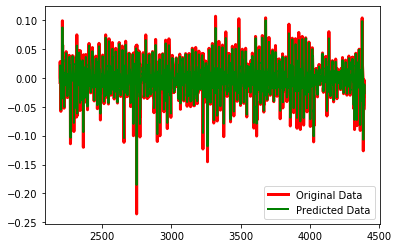

In [20]:
y = x_test[1:]
y_pred = x_test.ewm(alpha = alpha_optim).mean()[1:]
print("MSE for predicted data using EMA is ", mean_squared_error(y, y_pred, squared=False))
## Plotting predicted data predicted by EMA model and testing data.  
plt.plot(y, color='red', linewidth=3, label = 'Original Data')
plt.plot(y_pred, color = 'green', linewidth=2, label = 'Predicted Data')
plt.legend()
plt.show()

In [21]:
temp = train[len(train)-5:]
temp = [temp[i] for i in range(len(temp))]
coeff = model_fit.params

In [22]:
##Using the model coefficients to predicted values for test data.
preds = []
for i in test:
    l = len(temp)
    lag = [temp[i] for i in range(l-5,l)]
    y = coeff[0]
    for d in range(5):       
        y += coeff[d + 1] * lag[5 - d - 1]
    preds.append(y)
    temp.append(i)
print("MSE for predicted data using AR models is ",mean_squared_error(test,preds, squared = False))

MSE for predicted data using AR models is  0.021777976874336143


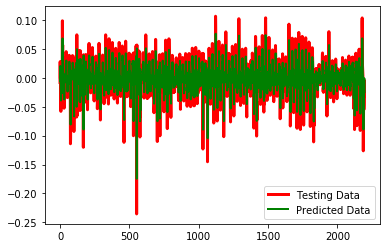

In [23]:
## Plotting predicted data predicted by AR model and testing data.  
plt.plot(test, color='red', linewidth=3, label = 'Testing Data')
plt.plot(preds, color = 'green', linewidth=2, label= 'Predicted Data')
plt.legend()
plt.show()

Comparing the results of above three models SMA, EMA and AR on training as well as on test datasets we can see that the AR model with a window of 1 performs the best amongst all with RMSE of 0.0 in training set ase well as on the testing data. Where the EMA model with alpha = 0.8 performs better than the AR model but has poor performance than the SMA with RMSE error of 0.00259155621094734 on traning data and 0.004742910756779176 on testing data. Now the lastly the AR(5) that is model with 5 lags has RMSE of 0.023770607122187582 on training dataset and 0.021777976874336143 on testing data. 